# Convolutional Neural Networks (CNNs)



## Cats vs Dogs

To learn about CNNs we will be working on a problem of great importance in computer vision, **classifying images of cats and dogs** :)

The problem is so important that there's even an easter egg in colab: go to `Tools -> Settings -> Miscellaneous and enable 'Kitty mode' and 'Corgi mode'` to get more cats and dogs to classify when you're tired of coding :)

### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [ ]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2024-03-31 06:34:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 64.233.189.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  20.4MB/s    in 3.2s    

2024-03-31 06:34:11 (20.4 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
! unzip -q cats_and_dogs_filtered.zip

### Dataset Organization
Our dataset contains two directories, `train` and `validation`, both containing two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats and 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a CNN to classify these images, i.e. given an image from this dataset, tell if it contains a *cat* or a *dog*.

```bash
├── dir.txt
├── train
│   ├── cats
│   │   ├── cat.0.jpg
│   │   ├── cat....jpg
│   │   ├── cat.999.jpg
│   └── dogs
│       ├── dog.0.jpg
│       ├── dog....jpg
│       ├── dog.999.jpg
├── validation
│   ├── cats
│   │   ├── cat.2000.jpg
│   │   ├── cat....jpg
│   │   └── cat.2499.jpg
│   └── dogs
│       ├── dog.2000.jpg
│       ├── dog....jpg
│       └── dog.2499.jpg
└── vectorize.py

6 directories, 3002 files
```

### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

 Torchvision is a Pytorch library with many commonly used tools in computer vision. In the case of computer vision, the datasets with the folder structure `label_name/image_file` are very common, and to process those there's already an implemented class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)).

 Another thing we need from Torchvision library is [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html). In computer vision, we very often want to transform the images in certain ways. The most common is **normalization**. Others include *flipping*, changing *saturation*, *hue*, *contrast*, *rotation*, and *blurring*.

 Below, we create training, validation and test sets. We use a few transforms for **augmentation** on the training set, but we don't use anything but **resize** and **normalization** for validation and test.

In [ ]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Inverse transformation which is needed for plotting.
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=Image.Resampling.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(), # This is necessary to convert PIL to torch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms)

validation_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [500, 500], generator=torch.Generator().manual_seed(42))

### Dataset Inspection
Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

torch.Size([3, 256, 256])


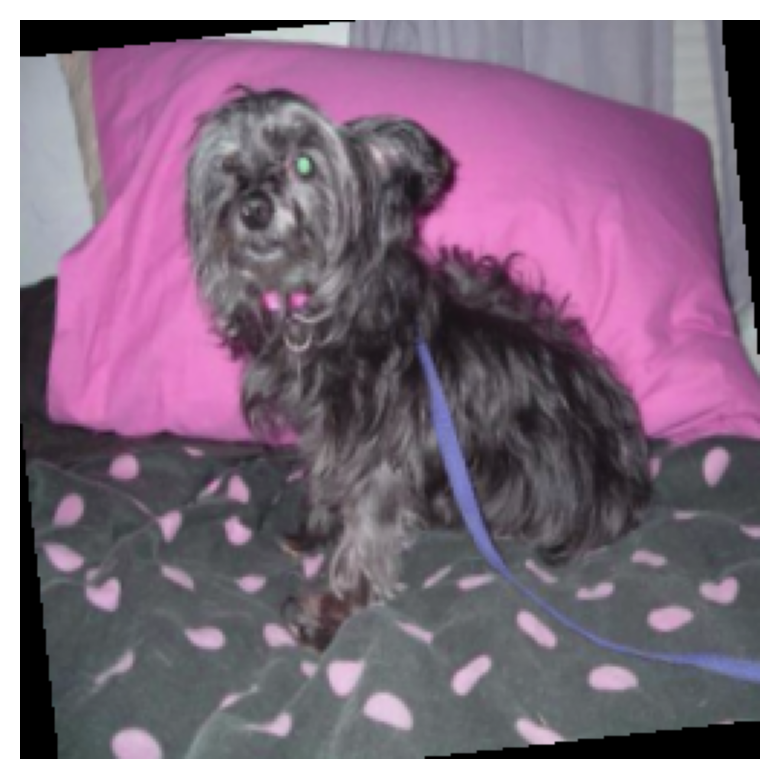

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(inv_normalize(img).detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
print(train_dataset[1000][0].shape)
show_normalized_image(train_dataset[1000][0])

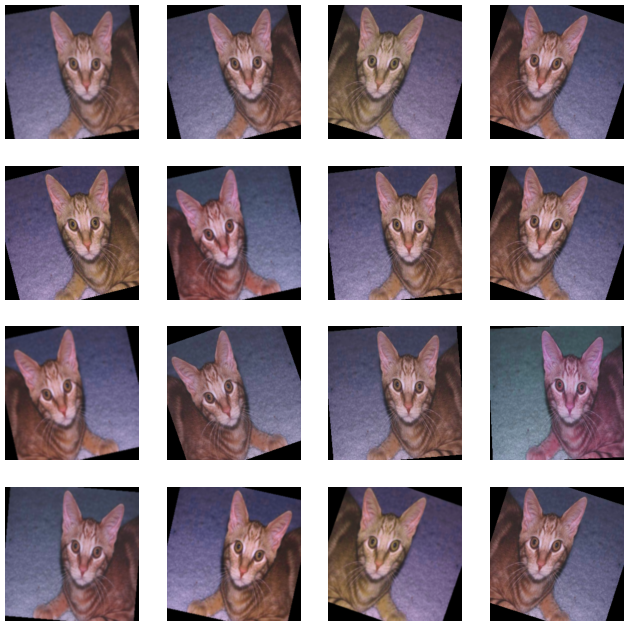

In [ ]:
# checking the augmentation
plt.rcParams['figure.dpi'] = 50
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    show_normalized_image(train_dataset[10][0])
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Creating the model

Now is the time to create a model.

All models in Pytorch are subclassing `torch.nn.Module`. We have to implement `__init__` and `forward` methods.


* Convolutional layers (at least two)
* Pooling layers
* Non-linearity
* Residual connections similar to that of **ResNet**
* fully connected layer(s)

Note that you cannot use Batch Normalization layers in this step.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_cat_dog(torch.nn.Module):

    def __init__(self,in_features=20,out_features=64,img_dimention=3,num_classes=2,shape=256):
        super().__init__()
        self.conv1=nn.Conv2d(img_dimention,in_features,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(in_features,out_features,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(out_features,out_features,kernel_size=3,stride=1,padding=1)
        self.convRes=nn.Conv2d(img_dimention,in_features,kernel_size=1)
        self.convRes2=nn.Conv2d(in_features,out_features,kernel_size=1)
        self.convRes3=nn.Conv2d(img_dimention,out_features,kernel_size=1)
        self.Shape=shape
        for i in range(3):
          self.Shape=(self.Shape-2)/2
        # self.fc1=nn.Linear(int(self.Shape)*out_features,100)
        self.fc1=nn.Linear(64*16*16,100)
        self.fc2=nn.Linear(100,64)
        self.fc3=nn.Linear(64,2)

    def forward(self, x):
        out=self.conv1(x)

        out=F.max_pool2d(out,2,2)
        out=F.relu(out)


        out=self.conv2(out)
        out=F.max_pool2d(out,2,2)
        out=F.relu(out)

        x=self.convRes3(x)
        x=F.max_pool2d(x,4,4)

        out=x+out

        out=self.conv3(out)
        out=F.max_pool2d(out,2,2)
        out=F.relu(out)


        out=self.conv3(out)
        out=F.max_pool2d(out,2,2)
        out=F.relu(out)

        # print(out.shape)
        out=F.relu(self.fc1(out.view(-1,64*16*16)))
        out=F.relu(self.fc2(out))
        out=self.fc3(out)
        return F.log_softmax(out,dim=1)


In [ ]:
net=CNN_cat_dog()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# print(train_dataset[10][0].shape)
for i , j in train_dataloader:
  break
# print(i.shape)
net(i).shape


torch.Size([32, 2])

In [ ]:
model = CNN_cat_dog()
model.to(device)

CNN_cat_dog(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convRes): Conv2d(3, 20, kernel_size=(1, 1), stride=(1, 1))
  (convRes2): Conv2d(20, 64, kernel_size=(1, 1), stride=(1, 1))
  (convRes3): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=16384, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

### Training the model



In [ ]:
from tqdm.notebook import tqdm
import torch.optim as optim

def get_loss_and_correct(model, batch, criterion, device):

    x_train , y_train= batch
    x_train,y_train = x_train.to(device),y_train.to(device)

    y_pred=model(x_train)
    loss=criterion(y_pred,y_train).to(device)
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()

    return loss , batch_corr



def step(loss, optimizer):

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
N_EPOCHS = 20
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=2)
model = CNN_cat_dog()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    # model.train()

    for batch in tqdm(train_dataloader, leave=False):

        loss, train_corr=get_loss_and_correct(model, batch, criterion, device)
        total_train_loss+=loss.item()
        total_train_correct+=train_corr.item()
        # print("total_train_correct",total_train_correct)
        # print("total_train_loss",total_train_loss)
        step(loss,optimizer)




    with torch.no_grad():
        for batch in validation_dataloader:

            val_loss, val_corr=get_loss_and_correct(model, batch, criterion, device)
            total_validation_loss +=val_loss.item()
            total_validation_correct += val_corr.item()

    mean_train_loss = total_train_loss/2000
    train_accuracy = total_train_correct*100/2000

    mean_validation_loss = total_validation_loss/500
    validation_accuracy = total_validation_correct*100/500

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

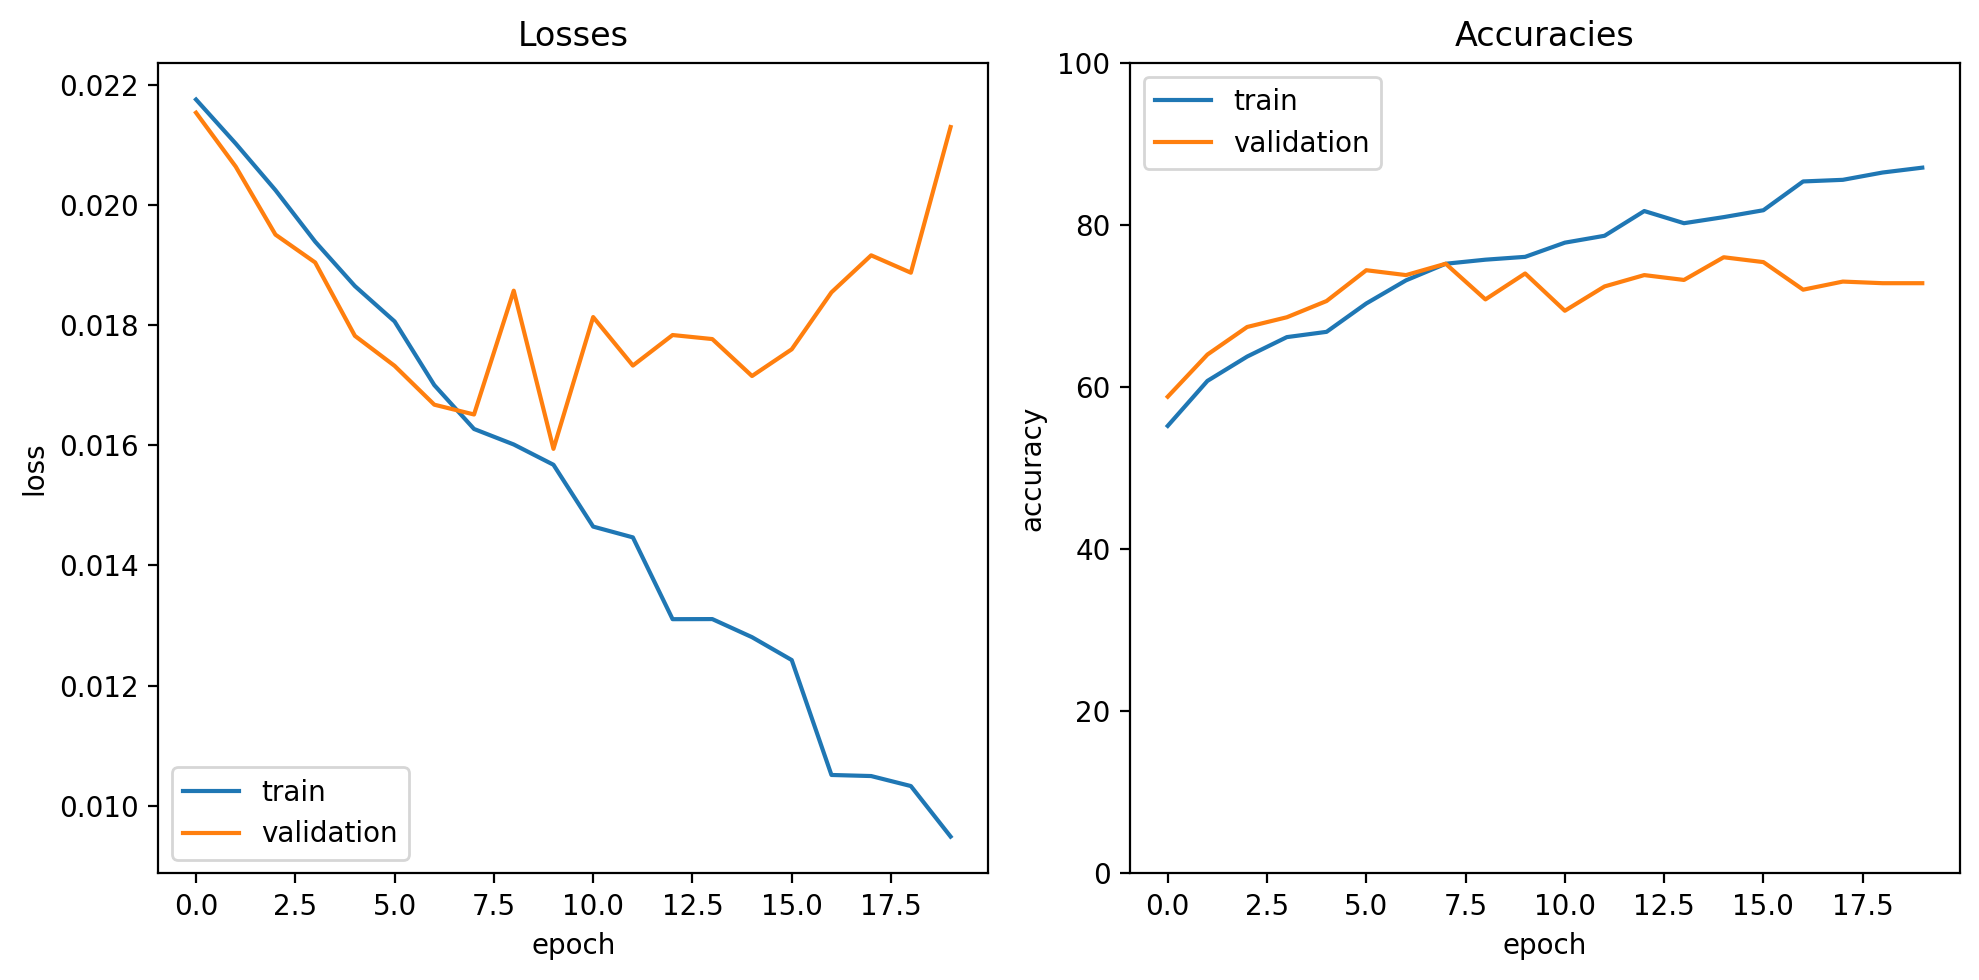

In [ ]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 100)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

In [ ]:
class ConvoltionalNeuralNetwork(nn.Module):

  def __init__(self,in_features=20,out_features=64,img_dimention=3,num_classes=2):
        super().__init__()
        self.conv1=nn.Conv2d(img_dimention,in_features,kernel_size=3,stride=1)
        self.bn1=nn.BatchNorm2d(in_features)
        self.conv2=nn.Conv2d(in_features,out_features,3,1,0)
        self.bn2=nn.BatchNorm2d(out_features)
        self.conv3=nn.Conv2d(out_features,out_features,3,1,0)
        self.bn3=nn.BatchNorm2d(out_features)
        self.conv4=nn.Conv2d(out_features,2*out_features,3,1,1)
        self.bn4=nn.BatchNorm2d(2*out_features)
        self.maxpool=nn.MaxPool2d(2,2)
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc1=nn.Linear(128*15*15,120)
        self.fc2=nn.Linear(120,50)
        self.fc3=nn.Linear(50,num_classes)


        self.out_features=2*out_features
        self.dropout = nn.Dropout(0.3)

  def forward(self,x):
        out=self.conv1(x)
        out=F.relu(self.bn1(self.maxpool(out)))
        out=self.conv2(out)
        out=F.relu(self.bn2(self.maxpool(out)))
        out=self.conv3(out)
        out=F.relu(self.bn3(self.maxpool(out)))
        out=self.conv4(out)
        out=F.relu(self.bn4(self.maxpool(out)))

        out=out.view(-1,self.out_features*15*15)
        out=self.dropout(out)
        out=F.relu(self.fc1(out))
        out=F.relu(self.fc2(out))
        out=self.fc3(out)



        return F.log_softmax(out,dim=1)

In [ ]:
net1=ConvoltionalNeuralNetwork()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# print(train_dataset[10][0].shape)
for i , j in train_dataloader:
  break
# print(i.shape)
net1(i).shape

torch.Size([32, 2])

In [ ]:
N_EPOCHS = 15
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=2)
model = ConvoltionalNeuralNetwork()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    # model.train()

    for batch in tqdm(train_dataloader, leave=False):

        loss, train_corr=get_loss_and_correct(model, batch, criterion, device)
        total_train_loss+=loss.item()
        total_train_correct+=train_corr.item()
        # print("total_train_correct",total_train_correct)
        # print("total_train_loss",total_train_loss)
        step(loss,optimizer)




    with torch.no_grad():
        for batch in validation_dataloader:

            val_loss, val_corr=get_loss_and_correct(model, batch, criterion, device)
            total_validation_loss +=val_loss.item()
            total_validation_correct += val_corr.item()

    mean_train_loss = total_train_loss/2000
    train_accuracy = total_train_correct*100/2000

    mean_validation_loss = total_validation_loss/500 #
    validation_accuracy = total_validation_correct*100/500 #

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [ ]:

total_test_loss=0
total_test_correct=0
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)
with torch.no_grad():
    for batch in test_dataloader:
        test_loss , test_corr=get_loss_and_correct(model, batch, criterion, device)
        total_test_loss +=test_loss.item()
        total_test_correct += test_corr
mean_test_loss=total_test_loss/500
test_acc=total_test_correct*100/500
print(f"My MODEL accuracy is {test_acc:.2f}% and  LOSS={mean_test_loss:.6f} ")

My MODEL accuracy is 76.60% and  LOSS=0.000930 


In [ ]:
torch.save(model.state_dict(), 'cat&dog-CNN-Model.pt')

In [ ]:
with torch.no_grad():

    x,y=batch
    x,y=x.to(device) , y.to(device)
    # print(y)
    y_predect=model(x)

In [ ]:
with torch.no_grad():
  predicted = torch.max(y_predect.data, 1)[1]
  print(y==predicted)

tensor([ True,  True,  True, False, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True, False,  True,  True, False, False,  True, False,  True, False,
         True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False, 

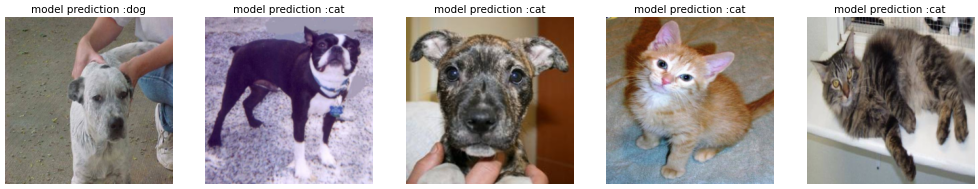

In [ ]:
import random
random_indx=[random.randint(0, 500) for _ in range(5)]
plt.figure(figsize=(25,20))
for i in range(len(random_indx)):
  if predicted[i]==0:
    class_="cat"
  else:
    class_="dog"

  plt.subplot(1,5,i+1)
  im1=test_dataset[random_indx[i]][0]
  show_normalized_image(im1)
  plt.title(f"model prediction :{class_}",fontdict={'fontsize': 15})


### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

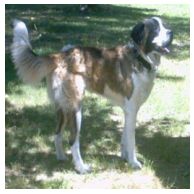

In [ ]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [ ]:

model=model.to("cpu")
clipped=nn.Sequential(*list(model.children())[:6])
clipped

Sequential(
  (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
input=validation_dataset[10][0]
input=input.reshape(1,3,256,256)
intermediate_output=clipped(input)
intermediate_output.shape

torch.Size([1, 64, 250, 250])

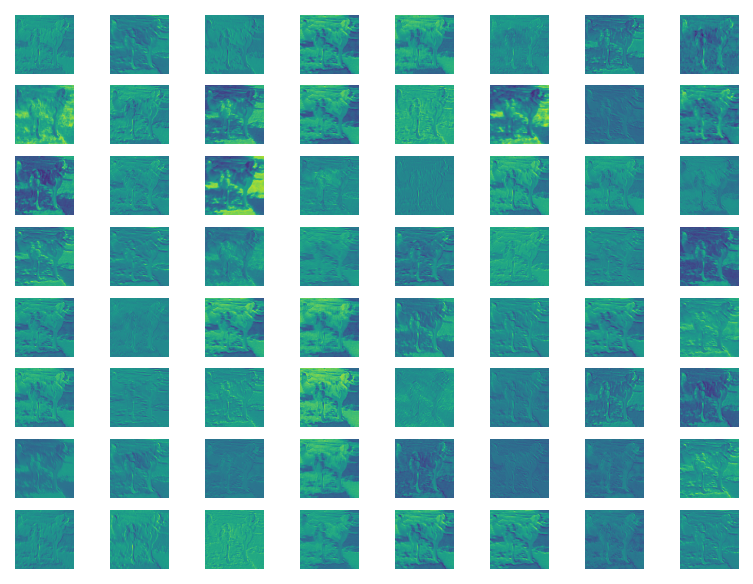

In [ ]:
import math

def plot_intermediate_output(result, title=None):
    """ Plots the intermediate output of shape
      N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')


plot_intermediate_output(result=intermediate_output)
